# Investigate the Data

In this project, we will be investigating the way people think about masculinity by applying the KMeans algorithm to data from  <a href="https://fivethirtyeight.com/" target = "_blank">FiveThirtyEight</a>. FiveThirtyEight is a popular website known for their use of statistical analysis in many of their stories.

FiveThirtyEight and WNYC made a masculinity survey to get their male readers' thoughts on masculinity. 

In the code block below, I've loaded `masculinity.csv` into a DataFrame named `survey`. This file contains the raw responses to the masculinity survey. Let's start getting a sense of how this data is structured. 


In [1]:
import pandas as pd

survey = pd.read_csv("masculinity.csv")

print(survey.columns)
print(len(survey))
print(survey.head())

Index(['Unnamed: 0', 'StartDate', 'EndDate', 'q0001', 'q0002', 'q0004_0001',
       'q0004_0002', 'q0004_0003', 'q0004_0004', 'q0004_0005', 'q0004_0006',
       'q0005', 'q0007_0001', 'q0007_0002', 'q0007_0003', 'q0007_0004',
       'q0007_0005', 'q0007_0006', 'q0007_0007', 'q0007_0008', 'q0007_0009',
       'q0007_0010', 'q0007_0011', 'q0008_0001', 'q0008_0002', 'q0008_0003',
       'q0008_0004', 'q0008_0005', 'q0008_0006', 'q0008_0007', 'q0008_0008',
       'q0008_0009', 'q0008_0010', 'q0008_0011', 'q0008_0012', 'q0009',
       'q0010_0001', 'q0010_0002', 'q0010_0003', 'q0010_0004', 'q0010_0005',
       'q0010_0006', 'q0010_0007', 'q0010_0008', 'q0011_0001', 'q0011_0002',
       'q0011_0003', 'q0011_0004', 'q0011_0005', 'q0012_0001', 'q0012_0002',
       'q0012_0003', 'q0012_0004', 'q0012_0005', 'q0012_0006', 'q0012_0007',
       'q0013', 'q0014', 'q0015', 'q0017', 'q0018', 'q0019_0001', 'q0019_0002',
       'q0019_0003', 'q0019_0004', 'q0019_0005', 'q0019_0006', 'q0019_0007',
      

In [2]:
print(survey["q0007_0001"].value_counts())
print(survey["q0007_0002"].value_counts())
print(survey["q0007_0003"].value_counts())
print(survey["q0007_0004"].value_counts())
print(survey["q0007_0005"].value_counts())
print(survey["q0007_0006"].value_counts())
print(survey["q0007_0007"].value_counts())
print(survey["q0007_0008"].value_counts())
print(survey["q0007_0009"].value_counts())
print(survey["q0007_0010"].value_counts())
print(survey["q0007_0011"].value_counts())


Sometimes                    537
Rarely                       324
Often                        142
Never, but open to it        123
Never, and not open to it     53
No answer                     10
Name: q0007_0001, dtype: int64
Sometimes                    514
Rarely                       387
Often                        123
Never, but open to it        101
Never, and not open to it     50
No answer                     14
Name: q0007_0002, dtype: int64
Sometimes                    364
Rarely                       339
Never, and not open to it    224
Often                        166
Never, but open to it         85
No answer                     11
Name: q0007_0003, dtype: int64
Rarely                       505
Sometimes                    371
Never, but open to it        121
Never, and not open to it     78
No answer                     71
Often                         43
Name: q0007_0004, dtype: int64
Never, and not open to it    710
Never, but open to it        228
Rarely            

# Mapping the Data

In order to start thinking about using the KMeans algorithm with this data, we need to turn the survey responses into numerical data. I will consider all the sub questions of question 7 as the main question to create the clusters. I can't cluster the data using the phrases `"Often"` or `"Rarely"`, so I need to turn those phrases into numbers.

* `"Often"` -> `4`
* `"Sometimes"` ->  `3`
* `"Rarely"` -> `2` 
* `"Never, but open to it"` -> `1`
* `"Never, and not open to it"` -> `0`.

Note that it's important that these responses are somewhat linear. `"Often"` is at one end of the spectrum with `"Never, and not open to it"` at the other. The other values fall in sequence between the two. 


In [3]:
cols_to_map = ["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004",
       "q0007_0005", "q0007_0006", "q0007_0007", "q0007_0008", "q0007_0009",
       "q0007_0010", "q0007_0011"]

for i in cols_to_map:
    survey[i] = survey[i].map({"Often": 4, "Sometimes": 3, "Rarely": 2, "Never, but open to it": 1, "Never, and not open to it": 0})
print(survey["q0007_0001"].value_counts())

3.0    537
2.0    324
4.0    142
1.0    123
0.0     53
Name: q0007_0001, dtype: int64


# Plotting the Data

I now have 11 different features to use in the KMeans algorithm. Before I jump into clustering, let's graph some of these features on a 2D graph. I will do a scatter plot using `survey["q0007_0001"]` and `survey["q0007_0002"]` as parameters. 


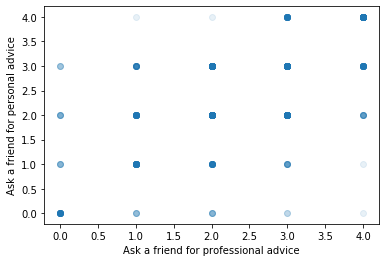

In [5]:
from matplotlib import pyplot as plt

plt.scatter(survey["q0007_0001"], survey["q0007_0002"], alpha = 0.1)
plt.xlabel("Ask a friend for professional advice")
plt.ylabel("Ask a friend for personal advice")
plt.show()


# Build the KMeans Model

It's now time to start clustering! There are so many interesting questions to ask about this data. Let's start by seeing if clusters form based on traditionally masculine concepts. 

After looking at the first four sub-questions in question 7. Those four activities aren't necessarily seen as traditionally masculine. On the other hand, sub-questions 5, 8, and 9 are often seen as very masculine activities. What would happen if I found 2 clusters based on those 7 questions? Would I find clusters that represent traditionally feminine and traditionally masculine people? Let's find out.

I first need to drop all of the rows that contain a `NaN` value in any of the columns I am interested in. I will create a new variable named `rows_to_cluster` and set it equal to the result of calling `dropna` on `survey`. `dropna` will have a parameter `subset` equal to a list of the 7 columns I want. 

I will create a `KMeans` object named `classifier` where `n_clusters = 2`. I also will create a `classifier`'s `.fit()` method. The parameter of `.fit()` should be the 7 columns I am interested in. 

In [6]:
from sklearn.cluster import KMeans

rows_to_cluster = survey.dropna(subset = ["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004", "q0007_0005", "q0007_0008", "q0007_0009"])

classifier = KMeans(n_clusters = 2)

classifier.fit(rows_to_cluster[["q0007_0001", "q0007_0002", "q0007_0003", "q0007_0004", "q0007_0005", "q0007_0008", "q0007_0009"]])
                               
print(classifier.cluster_centers_)


[[1.87830688 1.84391534 0.85185185 1.72486772 0.57142857 2.64021164
  1.97089947]
 [2.84548105 2.81632653 2.84110787 2.39941691 0.69387755 3.06997085
  2.90087464]]


# Separate the Cluster Members

When looking at the two clusters, the first four numbers represent the traditionally feminine activities and the last three represent the traditionally masculine activities. If the data points are separated into a feminine cluser and a masculine cluster, I would expect to see one cluster to have high values for the first four numbers and the other cluster to have high values for the last three numbers.

Instead, the first cluster has a low value in every feature. Since a low number or close to one means the person was more likely to never have done something, but open to it, the clusters seem to represent "never have do things but open to" and "people who rarely do things".

In order to find out more information about these clusters by looking at the specific members of each cluster. I will print `classifier.labels_`. This list shows which cluster every row in the DataFrame corresponds to.

For example,  if `classifier.labels_` was `[1, 0 ,1]`, then the first row in the DataFrame would be in cluster one, the second row would be in cluster 0, and the third row would be in cluster one. A row represents one persons answers to every question 7 in the survey.



In [7]:
print(classifier.labels_)
cluster_zero_indices = []
cluster_one_indices = []

for i in range(len(classifier.labels_)):
    if (classifier.labels_[i] == 0):
        cluster_zero_indices.append(i)
    else:
        cluster_one_indices.append(i)
        
print(cluster_zero_indices)        

[1 0 1 ... 0 0 0]
[1, 4, 6, 7, 9, 10, 12, 14, 17, 18, 19, 24, 29, 35, 39, 42, 49, 51, 52, 53, 54, 55, 57, 58, 62, 63, 65, 66, 75, 78, 79, 82, 84, 86, 87, 88, 89, 90, 92, 94, 95, 97, 98, 101, 106, 107, 109, 113, 116, 117, 118, 119, 123, 128, 129, 130, 131, 132, 134, 139, 142, 143, 154, 172, 175, 176, 178, 179, 180, 181, 184, 187, 189, 195, 196, 198, 199, 201, 209, 212, 222, 229, 230, 231, 233, 236, 237, 240, 241, 247, 248, 249, 250, 256, 260, 261, 263, 264, 272, 275, 281, 283, 284, 286, 288, 291, 296, 297, 299, 300, 301, 305, 310, 311, 325, 328, 331, 336, 337, 340, 341, 343, 347, 350, 351, 353, 361, 367, 369, 377, 378, 390, 391, 392, 393, 394, 396, 397, 398, 399, 409, 410, 411, 412, 415, 417, 418, 419, 425, 428, 429, 432, 449, 454, 455, 457, 459, 461, 463, 468, 470, 471, 476, 477, 478, 484, 489, 490, 493, 494, 496, 498, 499, 502, 508, 509, 510, 515, 516, 521, 523, 525, 526, 529, 531, 533, 542, 546, 549, 555, 556, 559, 560, 562, 563, 564, 566, 567, 570, 577, 579, 580, 585, 588, 589, 592,

# Investigate the Cluster Members

Now that we have the indices for each cluster, let's look at some stats about these two clusters. I will get the rows of the DataFrame that correspond to cluster zero by doing the following:

```py
cluster_zero_df = rows_to_cluster.iloc[cluster_zero_indices]
```

Finally, I will look at some information about these two clusters. Print the `value_counts()` of the `educ4` and `age3` column of each cluster. 

If I divide the result of `value_counts()` by the size of the cluster, I will get the percentage of people in each category rather than the total number. This will make it easier to compare the two clusters.

In [8]:
cluster_zero_df = rows_to_cluster.iloc[cluster_zero_indices]
cluster_one_df = rows_to_cluster.iloc[cluster_one_indices]

print(cluster_zero_df['educ4'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['educ4'].value_counts()/len(cluster_one_df))

print(cluster_zero_df['age3'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['age3'].value_counts()/len(cluster_one_df))

Some college            0.314815
College or more         0.285714
Post graduate degree    0.251323
High school or less     0.145503
Name: educ4, dtype: float64
Post graduate degree    0.365889
College or more         0.330904
Some college            0.230321
High school or less     0.072886
Name: educ4, dtype: float64
65 and up    0.502646
35 - 64      0.433862
18 - 34      0.060847
Name: age3, dtype: float64
35 - 64      0.478134
65 and up    0.454810
18 - 34      0.067055
Name: age3, dtype: float64


# Conclusion

By answering those 7 questions people don't fall into a "masculine" category or a "feminine" category. Instead, they seem to be divided by their level of education and their age!



In [10]:
print(cluster_zero_df['educ4'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['educ4'].value_counts()/len(cluster_one_df))

print(cluster_zero_df['age3'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['age3'].value_counts()/len(cluster_one_df))

Some college            0.314815
College or more         0.285714
Post graduate degree    0.251323
High school or less     0.145503
Name: educ4, dtype: float64
Post graduate degree    0.365889
College or more         0.330904
Some college            0.230321
High school or less     0.072886
Name: educ4, dtype: float64
65 and up    0.502646
35 - 64      0.433862
18 - 34      0.060847
Name: age3, dtype: float64
35 - 64      0.478134
65 and up    0.454810
18 - 34      0.067055
Name: age3, dtype: float64


In [12]:
print(cluster_zero_df['racethn4'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['racethn4'].value_counts()/len(cluster_one_df))

print(cluster_zero_df['q0035'].value_counts()/len(cluster_zero_df))
print(cluster_one_df['q0035'].value_counts()/len(cluster_one_df))

White       0.833333
Other       0.079365
Black       0.047619
Hispanic    0.037037
W           0.002646
Name: racethn4, dtype: float64
White       0.855685
Other       0.083090
Hispanic    0.034985
Black       0.026239
Name: racethn4, dtype: float64
Pacific               0.211640
South Atlantic        0.169312
Middle Atlantic       0.129630
Mountain              0.111111
East North Central    0.105820
West South Central    0.084656
West North Central    0.068783
East South Central    0.058201
New England           0.047619
Name: q0035, dtype: float64
South Atlantic        0.190962
Pacific               0.185131
Middle Atlantic       0.148688
East North Central    0.134111
West South Central    0.094752
Mountain              0.081633
West North Central    0.074344
New England           0.052478
East South Central    0.027697
Name: q0035, dtype: float64
